#1. Setup

Load the Google Drive folder


In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/IDLI-VarDial2022

/content/drive/My Drive/Colab Notebooks/IDLI-VarDial2022


#2a. Prepare training data: Sentences

Prepare sentences and preprocess

In [3]:
import re
from sklearn.model_selection import train_test_split
import string

X_sentences, y_sentences = [], []

for line in open('sentences.txt', encoding='utf-8', errors='ignore'):
  label, sentence = line[:3], line[4:]
  if label.strip() not in {}:
    y_sentences.append(label.lower().strip())
    sentence = re.sub('http.*|thumb.*|&l.*|[kc]m²?', '', sentence)
    tbl = sentence.maketrans('', '', '#$%&()*+,-./:;<=>?!@[\]"^_`{|}~0123456789|‘”–„…\n\t°’')
    sentence = sentence.translate(tbl)
    sentence = re.sub('^M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$', '', sentence)
    X_sentences.append(sentence.lower())

X_train, X_test_sentences, y_train, y_test_sentences = train_test_split(X_sentences, y_sentences, shuffle=True, stratify=y_sentences, test_size=0.2, random_state=1)



#2b. Prepare training data: Wikipedia pages

Extract sentences from Wikipedia pages, preprocess them, and add them to training set

In [4]:
import os
import json
import pandas as pd
import ast
import random
from collections import Counter, defaultdict

# This loads data from Wikipedia dumps
root_folder = 'Wikipedia_pages/'
folders = ['nap_texts', 'lld_texts', 'eml_texts'] # 'roa_tara_texts'

for folder in folders:
  for file in os.listdir(root_folder + folder + '/AA'):
    for line in open(root_folder + folder + '/AA/' + file, encoding='utf-8', errors='ignore'):
      if len(line) > 200:
        y_train.append(folder[:3].strip('_'))
        sentence = ast.literal_eval(line)['text']
        sentence = re.sub('http.*|thumb.*|&l.*|[kc]m²?', '', sentence)
        tbl = sentence.maketrans('', '', '#$%&()*+,-./:;<=>?!@[\]"^_`{|}~0123456789|‘”–„…\n\t°’')
        sentence = sentence.translate(tbl)
        #roman numbers
        sentence = re.sub('^M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$', '', sentence)
        X_train.append(sentence.lower())

label_list = sorted(list(set(y_train)))
print(len(label_list))

10


#3. Train and evaluate a NaiveBayes classifier


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# vectorize the training data
SIZE = 10000
vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(1,5), max_features=SIZE)
X_train_NB = vectorizer.fit_transform(X_train)

print('Matrix calculated. Training data: ')
print('Rows x: %s' %X_train_NB.shape[0])
print('Columns x: %s' %X_train_NB.shape[1])

# train a Naive Bayes classifier
model_nb = MultinomialNB()
model_nb.fit(X_train_NB, y_train)

print('Classifier trained.')

X_test_NB = vectorizer.transform(X_test_sentences)
y_pred_nb = model_nb.predict(X_test_NB)

print('\nClassification Report:')
print(classification_report(y_test_sentences, y_pred_nb))


Matrix calculated. Training data: 
Rows x: 27470
Columns x: 10000
Classifier trained.

Classification Report:
              precision    recall  f1-score   support

         fur       0.99      1.00      0.99       135
         lij       0.98      0.99      0.99       124
         lld       0.00      0.00      0.00         0
         lmo       0.99      0.94      0.96       246
         nap       0.00      0.00      0.00         0
         pms       0.99      1.00      0.99       238
          sc       0.96      0.93      0.94        96
         scn       0.96      0.99      0.97       274
         vec       0.98      0.96      0.97       247

    accuracy                           0.97      1360
   macro avg       0.76      0.76      0.76      1360
weighted avg       0.98      0.97      0.98      1360



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#4. Train a DNN


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

X_train_tf = X_train_NB.todense()
y_train_tf = np.array([label_list.index(label) for label in y_train], dtype='d')

X_test_tf = X_test_NB.todense()
y_test_tf = np.array([label_list.index(label) for label in y_test_sentences], dtype='d')

In [7]:
# this is the vanilla network
model_dnn = tf.keras.Sequential()
# it has just two dense layers
model_dnn.add(tf.keras.layers.Dense(units=50, name='fc_1', activation='relu'))
model_dnn.add(tf.keras.layers.Dropout(rate=0.5))
model_dnn.add(tf.keras.layers.Dense(units=50, name='fc_2', activation='relu'))
model_dnn.add(tf.keras.layers.Dropout(rate=0.5))
model_dnn.add(tf.keras.layers.Dense(units=10, name='linear'))

model_dnn.build(input_shape=(None,SIZE))

model_dnn.summary()

# compile the model
model_dnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

N_EPOCHS = 10

history = model_dnn.fit(X_train_tf, y_train_tf, epochs=N_EPOCHS, validation_data=(X_test_tf, y_test_tf), shuffle=True, batch_size=4)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc_1 (Dense)                (None, 50)                500050    
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 fc_2 (Dense)                (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 linear (Dense)              (None, 10)                510       
                                                                 
Total params: 503110 (1.92 MB)
Trainable params: 503110 (1.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
6868/6868

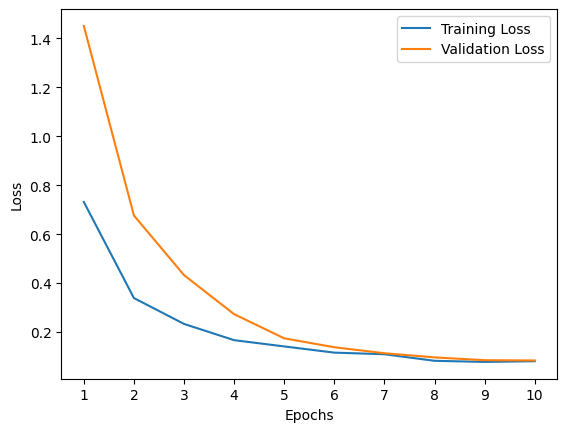

In [8]:
epochs = range(1, N_EPOCHS+1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

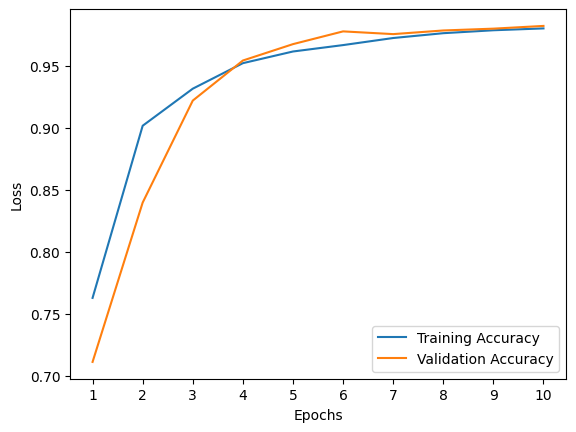

In [9]:
# plot training and validation accuracy
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
# calculate accuracy on the test dataset
y_pred_nn = [label_list[np.argmax(out)] for out in model_dnn.predict(X_test_tf)]

print('\nClassification Report:')
print(classification_report(y_test_sentences, y_pred_nn))

43/43 [==============================] - 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

         eml       0.00      0.00      0.00         0
         fur       1.00      1.00      1.00       135
         lij       1.00      0.98      0.99       124
         lmo       0.99      0.96      0.98       246
         nap       0.00      0.00      0.00         0
         pms       0.99      1.00      0.99       238
          sc       1.00      0.97      0.98        96
         scn       0.97      0.99      0.98       274
         vec       0.97      0.97      0.97       247

    accuracy                           0.98      1360
   macro avg       0.77      0.76      0.77      1360
weighted avg       0.99      0.98      0.98      1360



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##6. Train a CNN

In [11]:
# determine the number of characters to use in the vocabulary
SIZE = 50

# fit a character-tokenizer on the texts
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=SIZE, char_level=True, oov_token=0)
tokenizer.fit_on_texts(X_train)

# transform the training set in a sequence of numbers, add padding, and transform it into one-hot encoding representation
X_train_tf = tokenizer.texts_to_sequences(X_train)
X_train_tf = tf.keras.preprocessing.sequence.pad_sequences(X_train_tf, maxlen=160)
X_train_tf = tf.keras.utils.to_categorical(X_train_tf, num_classes=SIZE, dtype='d')

# repeat the process for the test set
X_test_tf = tokenizer.texts_to_sequences(X_test_sentences)
X_test_tf = tf.keras.preprocessing.sequence.pad_sequences(X_test_tf, maxlen=160)
X_test_tf = tf.keras.utils.to_categorical(X_test_tf, num_classes=SIZE, dtype='d')

# create a one-hot encoding vector for the labels
y_train_tf = np.array([label_list.index(label) for label in y_train], dtype='d')
y_test_tf = np.array([label_list.index(label) for label in y_test_sentences], dtype='d')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv1D)             (None, 160, 256)          38656     
                                                                 
 pool_1 (MaxPooling1D)       (None, 53, 256)           0         
                                                                 
 conv_2 (Conv1D)             (None, 53, 128)           98432     
                                                                 
 pool_2 (MaxPooling1D)       (None, 17, 128)           0         
                                                                 
 flatten (Flatten)           (None, 2176)              0         
                                                                 
 fc_1 (Dense)                (None, 50)                108850    
                                                                 
 dropout_2 (Dropout)         (None, 50)               

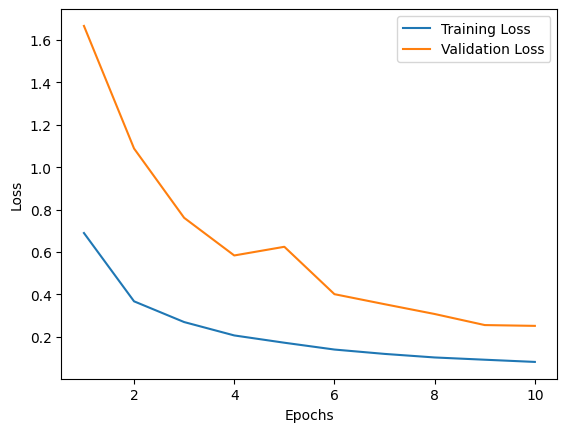

In [12]:
# this is the CNN network
model_cnn = tf.keras.Sequential()
# it starts with three convolutional layers followed by max pooling
model_cnn.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, strides=1, padding='same', name='conv_1', activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool1D(pool_size=3, name='pool_1'))
model_cnn.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same', name='conv_2', activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool1D(pool_size=3, name='pool_2'))
#the output is flattened and sent to a fully connected layer
model_cnn.add(tf.keras.layers.Flatten())
model_cnn.add(tf.keras.layers.Dense(units=50, name='fc_1', activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(rate=0.5))
model_cnn.add(tf.keras.layers.Dense(units=10, name='linear'))

model_cnn.build(input_shape=(None,160,SIZE))

# store the default_weights. This is useful to reset the network.
default_states = model_cnn.get_weights()

#print a summary of the model
model_cnn.summary()

# set the number of epochs
N_EPOCHS = 10

# compile the model
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# save the history of the model for evaluation
history = model_cnn.fit(X_train_tf, y_train_tf, epochs=N_EPOCHS, validation_data=(X_test_tf, y_test_tf), shuffle=True, batch_size=4)

# plot training and validation loss
epochs = range(1, N_EPOCHS+1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

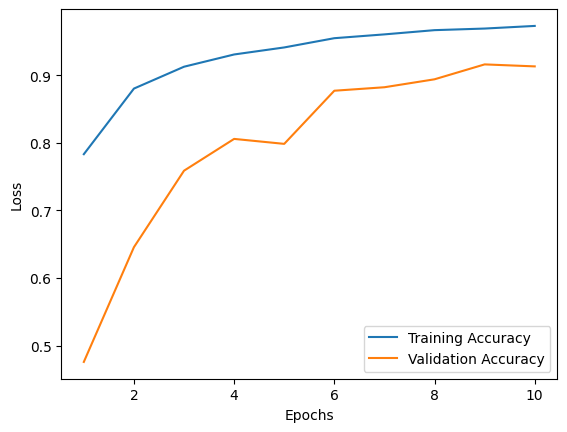

43/43 [==============================] - 0s 5ms/step
[('scn', 305), ('vec', 239), ('lmo', 233), ('pms', 227), ('fur', 138), ('lij', 123), ('sc', 89), ('lld', 3), ('nap', 2), ('eml', 1)]

Classification Report:
              precision    recall  f1-score   support

         eml       0.00      0.00      0.00         0
         fur       0.97      0.99      0.98       135
         lij       0.99      0.98      0.99       124
         lld       0.00      0.00      0.00         0
         lmo       0.88      0.84      0.86       246
         nap       0.00      0.00      0.00         0
         pms       1.00      0.95      0.98       238
          sc       0.82      0.76      0.79        96
         scn       0.88      0.97      0.92       274
         vec       0.89      0.86      0.88       247

    accuracy                           0.91      1360
   macro avg       0.64      0.64      0.64      1360
weighted avg       0.92      0.91      0.91      1360



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# plot training and validation accuracy
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# calculate accuracy on the test dataset
y_pred = [label_list[np.argmax(out)] for out in model_cnn.predict(X_test_tf)]

print(Counter(y_pred).most_common())

print('\nClassification Report:')
print(classification_report(y_test_sentences, y_pred))


#7. Train a BERT model


In [14]:
# install simpletransformers
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 61.0 M

In [15]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "num_train_epochs": 2,
             "save_eval_checkpoints" : False,
             "save_model_every_epoch": False,
             "save_optimizer_and_scheduler" : False,
             "save_steps": False}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "dbmdz/bert-base-italian-xxl-cased",
    #"bert", "fine_tuned_bert-base-italian-xxl-cased_2",
    num_labels=10,
    args=train_args
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-xxl-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

In [16]:
train_df = pd.DataFrame([[X,label_list.index(y)] for X,y in zip(X_train,y_train)], columns=['text', 'label'])
test_df = pd.DataFrame([[X,label_list.index(y)] for X,y in zip(X_test_sentences,y_test_sentences)], columns=['text', 'label'])

print(train_df.shape)
print(test_df.shape)

(27470, 2)
(1360, 2)


In [17]:
model.train_model(train_df)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:611: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/27470 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/3434 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/3434 [00:00<?, ?it/s]

(6868, 0.11110119991776382)

In [18]:
model.model.save_pretrained('fine_tuned_bert-base-italian-xxl-cased_2')
model.tokenizer.save_pretrained('fine_tuned_bert-base-italian-xxl-cased_2')
model.config.save_pretrained('fine_tuned_bert-base-italian-xxl-cased_2')

In [19]:
predictions, raw_outputs = model.predict(X_test_sentences)

  0%|          | 0/1360 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

In [20]:
print('\nClassification Report:')
print(classification_report(test_df['label'], predictions))


Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.99      0.98       135
           2       0.98      0.99      0.99       124
           4       0.96      0.96      0.96       246
           5       0.00      0.00      0.00         0
           6       0.99      0.98      0.99       238
           7       0.99      0.90      0.94        96
           8       0.96      0.97      0.97       274
           9       0.96      0.96      0.96       247

    accuracy                           0.97      1360
   macro avg       0.85      0.84      0.85      1360
weighted avg       0.97      0.97      0.97      1360



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
